<font color=green>
    
# Dogs vs Cats </font>

구글 드라이브 문서에 있는 dogs-vs-cats.zip을 다운받으셔서 압축을 풀고 진행하시면 됩니다.  
숙제는 목차의 `3. Modeling`부분을 작성해서 test 데이터에 대해서 `75퍼 이상의 Acc`를 내시면 됩니다.  
당연히 전체적으로 문서를 뒤엎어 고쳐도 상관없습니다. 모델 깊게 쌓아보거나, 하이퍼파라미터를 수정할 수도 있고, 데이터 자체에 대한 정규화를 해서 적용시킬수도 있고, lr_sche를 추가해볼수도 있고, data_augmentation을 추가할수도 있고, 비용함수나 최적화기법을 바꿀수도, dropout, batch_norm, initialization 기법 등 전에 배웠거나 안배웠던 것들도 모두 사용하시면 됩니다.     


해당 데이터는 케글에서 가져온 것으로 검색해보면 정말 많은 모델링을 찾아보실 수 있습니다.  
복붙은 하지 말되 따라치면서 공부하는 것이라도 좋으니 어떻게든 75퍼 이상의 모델링을 해내셔서 제출하시길 바랍니다.
전이학습은 안됩니다. 월등한 점수를 내기보다 연습한다는 생각으로 모델 아키텍을 해보시길 바랍니다.


참고로 한번 모델링 돌리면 적어도 30분이상으로 돌아갑니다. 돌아가는 동안 다음으로 해볼 것들 미리 아키텍 해두시면서 좋은 성능 내시길 바랍니다. 코랩과 놋북 둘다 같이해서 한번에 두 개의 모델링을 돌리실수도 있겠네요.


ps. 이번주에는 모든 조에 멘토들이 스터디에 같이 참여할 예정입니다.


   **< 목차 >**
1. Setting
 - 1) Import libraries
 - 2) Hyperparameters
2. Data
 - 1) Get Images
 - 2) Use DataLoader
 - 3) Check Images
3. Modeling
4. Loss Function & Optimizer
5. Train
 - 1) Train
 - 2) Test

## 1. Settings

#### 1) Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F

from PIL import Image
import numpy as np
import time
import matplotlib.pyplot as plt

#### 2) Hyperparamters

In [2]:
batch_size = 16
learning_rate = 0.003
epochs = 10
image_size = 196

# data augmentation
train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    #transforms.CenterCrop(196), 
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((image_size,image_size)),
    transforms.ToTensor(),
])

## 2. Data

#### 1) Get Images

In [3]:
# dir 각자 데이터 압축푼 폴더에 맞게 수정

train_dir = './cat_dog_images/train'
train_data = datasets.ImageFolder(root=train_dir, transform=train_transforms)

valid_dir = './cat_dog_images/valid'
valid_data = datasets.ImageFolder(root=valid_dir, transform=test_transforms)

test_dir = './cat_dog_images/test'
test_data = datasets.ImageFolder(root=test_dir, transform=test_transforms)

#### 2) Use DataLoader

In [4]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)
# drop_last 처리로 해줘야 하는 이유: 마지막에 배치에 안맞게 데이터 몇개 남을시 forward에서 view이후 size_mismatch오류가 일어남
print(f'train images: {len(train_loader.dataset)}')
print(f'valid images: {len(valid_loader.dataset)}')
print(f'test images: {len(test_loader.dataset)}')

train images: 20000
valid images: 2500
test images: 2500


#### 3) Check Images

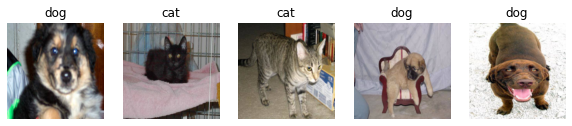

In [5]:
np.random.seed(42)
random_nums = [np.random.randint(1, 20001) for i in range(5)]

plt.figure(figsize=(10, 2))
for i in range(len(random_nums)):
    plt.subplot(1, 5, i+1)
    plt.imshow(np.transpose(train_loader.dataset[random_nums[i]][0], (1,2,0)))
    plt.title(f'{"cat" if train_loader.dataset[random_nums[i]][1] == 0 else "dog"}')
    plt.axis('off')

## 3. Modeling

In [6]:
# activation function

class MishFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return x * torch.tanh(F.softplus(x))   # x * tanh(ln(1 + exp(x)))

    @staticmethod
    def backward(ctx, grad_output):
        x = ctx.saved_variables[0]
        sigmoid = torch.sigmoid(x)
        tanh_sp = torch.tanh(F.softplus(x)) 
        return grad_output * (tanh_sp + x * sigmoid * (1 - tanh_sp * tanh_sp))

class Mish(nn.Module):
    def forward(self, x):
        return MishFunction.apply(x)

def to_Mish(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, Mish())
        else:
            to_Mish(child)

In [7]:
# nn.Module을 상속받는 CNN 클래스로 모델 작성(클래스명 바꾸어도 되고 밑에 똑같이 수정만 하면 됨.)
# 모델링 자유: 단순히 conv, relu, pooling만 번갈아하면 점수 안나옴. 2주차에 배운 것들 활용하면 금방 점수 개선됨.

drop_prob = 0.3           # drop_prob는 hyper parameter이므로 미리 설정한다.
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            Mish(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            Mish(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            #nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            Mish(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            Mish(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        )
        
        self.fc1 = nn.Linear(13*13*256, 256, bias=True)
        nn.init.xavier_uniform_(self.fc1.weight)

        self.layer5 = nn.Sequential(
            self.fc1,
            nn.BatchNorm1d(256),
            Mish(),
            nn.Dropout(p = drop_prob)
        )
        
        self.fc2 = nn.Linear(256, 2, bias=True)
        nn.init.xavier_uniform_(self.fc2.weight)
        
        self.layer6 = nn.Sequential(
            self.fc2,
            nn.LogSoftmax(dim=1)
        )
        
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.layer5(out)
        out = self.layer6(out)
        return out

modeling 이후 train_loader에서 next와 iter메소드를 통해서 batch 데이터셋 하나를 꺼내서 실험적으로 적용해보고,  
모델링에 대한 오류가 있는지 확인후 gpu에 올려서 본격적으로 훈련시작하는 것을 추천.

굳이 할 필요 없겠다 싶으면 안해도 됨

## 4. Loss_funtion & Optimizer

In [8]:
import gc 
gc.collect()
torch.cuda.empty_cache()

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'
print(device)

model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
#optimizer = RAdam(model_al.parameters(), lr = Learning_Rate)   
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,10,15], gamma= 0.95)
print(model)

cuda
CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Bat

## 5. Train

#### **1) Train**

In [10]:
train_loss_arr = []
valid_loss_arr = []

for epoch in range(epochs):
    start = time.time()
    train_avg_loss = 0
    model.train()
    for image, label in train_loader:
        # ------- assign train data
        image = image.to(device)
        label = label.to(device)
        # ------- forward prop
        optimizer.zero_grad()
        output = model(image)
        # ------- backward prop
        loss = loss_func(output, label)
        loss.backward()
        optimizer.step()
        # ------- get train performance
        train_avg_loss += loss / len(train_loader)
    train_loss_arr.append(train_avg_loss)
    print(f'Epoch : {epoch+1}/{epochs}, train_loss : {train_avg_loss:.4f}', end=' / ')
     
    model.eval()
    with torch.no_grad():
        valid_acc=0
        valid_avg_loss =0
        for image, label in valid_loader:
            # ------- assign valid data
            image = image.to(device)
            label = label.to(device)
            # ------- forward prop
            val_output = model(image)
            val_loss = loss_func(val_output,label)
            # ------- get valid performance
            val_batch_acc = ((val_output.argmax(dim=1) == label).float().mean()) # acc = 맞춘 개수 / 배치사이즈
            valid_acc += val_batch_acc / len(valid_loader) # acc / total_Iteration 
            valid_avg_loss += val_loss / len(valid_loader) # val_loss / total_Iteration
        valid_loss_arr.append(valid_avg_loss) 
        print(f'val_loss : {valid_avg_loss:.4f}, valid_acc : {valid_acc:.4f}, takes {time.time() - start}secs')

<ipython-input-6-a86d021ba30b>:11: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  x = ctx.saved_variables[0]


Epoch : 1/10, train_loss : 0.6254 / val_loss : 0.5525, valid_acc : 0.7340, takes 330.32021284103394secs
Epoch : 2/10, train_loss : 0.4736 / val_loss : 0.4523, valid_acc : 0.7901, takes 330.057843208313secs
Epoch : 3/10, train_loss : 0.4008 / val_loss : 0.3744, valid_acc : 0.8357, takes 330.08891797065735secs
Epoch : 4/10, train_loss : 0.3548 / val_loss : 0.3091, valid_acc : 0.8574, takes 330.1031093597412secs
Epoch : 5/10, train_loss : 0.2940 / val_loss : 0.3826, valid_acc : 0.8433, takes 330.18203568458557secs
Epoch : 6/10, train_loss : 0.2468 / val_loss : 0.2664, valid_acc : 0.8930, takes 330.15927147865295secs
Epoch : 7/10, train_loss : 0.2138 / val_loss : 0.2133, valid_acc : 0.9067, takes 330.1398916244507secs
Epoch : 8/10, train_loss : 0.1886 / val_loss : 0.2075, valid_acc : 0.9163, takes 343.51184153556824secs
Epoch : 9/10, train_loss : 0.1689 / val_loss : 0.1923, valid_acc : 0.9239, takes 340.04123163223267secs
Epoch : 10/10, train_loss : 0.1526 / val_loss : 0.2134, valid_acc : 

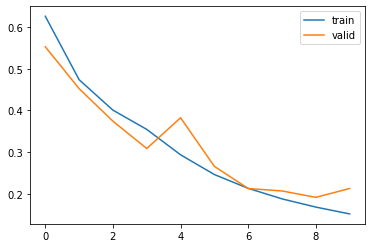

In [11]:
plt.plot(train_loss_arr, label='train')
plt.plot(valid_loss_arr, label='valid')
plt.legend()
plt.show()

#### **2) Test**

In [12]:
with torch.no_grad():
    start = time.time()
    test_acc=0
    model.eval()
    for image, label in test_loader:
        # ------- assign valid data
        image = image.to(device)
        label = label.to(device)
        # ------- forward prop
        test_output = model(image)
        # ------- get valid performance
        test_batch_acc = ((test_output.argmax(dim=1) == label).float().mean()) # acc = 맞춘 개수 / 배치사이즈
        test_acc += test_batch_acc / len(test_loader) # acc / total_Iteration 
    print(f'test_acc : {test_acc:.4f}, takes {time.time() - start}secs')
    
# Adam 0.3 / 92.63
# 128 / 89.42

test_acc : 0.9091, takes 13.884724140167236secs


**Fin** ────────────────────────────────────────────────────────────────────────────────────────────────